# Jonathan Halverson
# Wednesday, February 7, 2018
# Spam classification updated to Spark 2

In this notebook we build a ham/spam classifier for emails. We begin by preprocessing the text:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.driver.host", "localhost").getOrCreate()

In [3]:
import pyspark
pyspark.__version__

'2.2.1'

Read in the raw data and relabel the columns of the dataframe:

In [4]:
texts = spark.read.csv('smsspamcollection/SMSSpamCollection', sep='\t', header=False, inferSchema=True)
texts = texts.withColumnRenamed('_c0', 'label').withColumnRenamed('_c1', 'messages')
texts.show(5)

+-----+--------------------+
|label|            messages|
+-----+--------------------+
|  ham|Go until jurong p...|
|  ham|Ok lar... Joking ...|
| spam|Free entry in 2 a...|
|  ham|U dun say so earl...|
|  ham|Nah I don't think...|
+-----+--------------------+
only showing top 5 rows



Convert labels to numerical values and change data type:

In [5]:
from pyspark.sql.functions import regexp_replace

texts = texts.withColumn('label', regexp_replace('label', 'ham',  '0'))\
             .withColumn('label', regexp_replace('label', 'spam', '1'))
df = texts.withColumn('label', texts['label'].cast('int'))
texts.show(3)

+-----+--------------------+
|label|            messages|
+-----+--------------------+
|    0|Go until jurong p...|
|    0|Ok lar... Joking ...|
|    1|Free entry in 2 a...|
+-----+--------------------+
only showing top 3 rows



In [6]:
df.printSchema()

root
 |-- label: integer (nullable = true)
 |-- messages: string (nullable = true)



In [7]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import re

def clean_messages(message):
     letters_only = re.sub("[^a-zA-Z]", " ", message)
     words = letters_only.lower().split()
     return " ".join(words)

In [8]:
trans_udf = udf(clean_messages, StringType())
df = df.withColumn('messages', trans_udf(df.messages))

In [9]:
df.select('messages').show(10)

+--------------------+
|            messages|
+--------------------+
|go until jurong p...|
|ok lar joking wif...|
|free entry in a w...|
|u dun say so earl...|
|nah i don t think...|
|freemsg hey there...|
|even my brother i...|
|as per your reque...|
|winner as a value...|
|had your mobile m...|
+--------------------+
only showing top 10 rows



In [10]:
df.printSchema()

root
 |-- label: integer (nullable = true)
 |-- messages: string (nullable = true)



Let's plot the number of words per email:

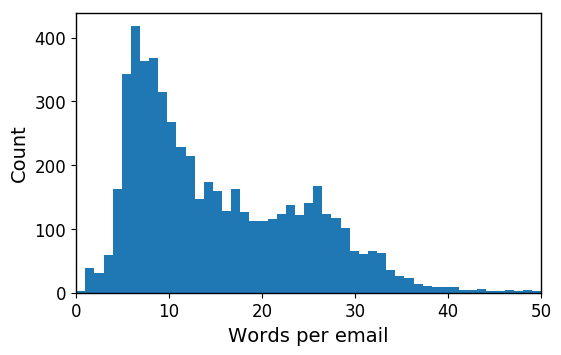

In [11]:
plt.hist(df.select('messages').rdd.map(lambda x: len(x[0].split())).collect(), bins=51, range=(0, 50))
plt.xlim(0, 50)
plt.xlabel('Words per email')
plt.ylabel('Count')

Create a test train split:

In [12]:
df_train, df_test = df.randomSplit([0.7, 0.3], seed=42)

Compute the class weights:

In [13]:
df_train_counts = df_train.groupby('label').count().toPandas()
df_train_counts

,label,count
0,1,522
1,0,3417


In [14]:
class_0_count = df_train_counts[df_train_counts.label == 0]['count'].values[0]
class_1_count = df_train_counts[df_train_counts.label == 1]['count'].values[0]
class_0_weight = df_train.count() / float(2 * class_0_count)
class_1_weight = df_train.count() / float(2 * class_1_count)
class_0_weight, class_1_weight

(0.5763827919227392, 3.7729885057471266)

In [15]:
from pyspark.sql import functions as F

df_train = df_train.select(df_train.messages, df_train.label,\
                           F.when(df_train.label == 0, class_0_weight)\
                            .when(df_train.label == 1, class_1_weight).alias('weight'))
df_test = df_test.select(df.messages, df_test.label,\
                         F.when(df_test.label == 0, class_0_weight)\
                          .when(df_test.label == 1, class_1_weight).alias('weight'))
df_train.show(5)

+--------------------+-----+--------------+
|            messages|label|        weight|
+--------------------+-----+--------------+
|                    |    0|0.576382791923|
|a bit of ur smile...|    0|0.576382791923|
|a bloo bloo bloo ...|    0|0.576382791923|
|a boy loved a gal...|    0|0.576382791923|
|a boy loved a gal...|    0|0.576382791923|
+--------------------+-----+--------------+
only showing top 5 rows



In [16]:
df_train.printSchema()

root
 |-- messages: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- weight: double (nullable = true)



The text is converted to word count vectors (bag of words):

In [17]:
from pyspark.ml.feature import HashingTF, Tokenizer, IDF

In [18]:
tf = HashingTF(numFeatures=5000, inputCol='words', outputCol='rawFeatures')
tokenizer = Tokenizer(inputCol="messages", outputCol="words")
wordsData = tokenizer.transform(df_train)

In [19]:
featurizedData = tf.transform(wordsData)
featurizedData.show(3)

+--------------------+-----+--------------+--------------------+--------------------+
|            messages|label|        weight|               words|         rawFeatures|
+--------------------+-----+--------------+--------------------+--------------------+
|                    |    0|0.576382791923|                  []| (5000,[3372],[1.0])|
|a bit of ur smile...|    0|0.576382791923|[a, bit, of, ur, ...|(5000,[310,572,72...|
|a bloo bloo bloo ...|    0|0.576382791923|[a, bloo, bloo, b...|(5000,[329,387,68...|
+--------------------+-----+--------------+--------------------+--------------------+
only showing top 3 rows



In [20]:
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData).cache()

In [21]:
rescaledData.printSchema()

root
 |-- messages: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rawFeatures: vector (nullable = true)
 |-- features: vector (nullable = true)



In [22]:
rescaledData.show(3)

+--------------------+-----+--------------+--------------------+--------------------+--------------------+
|            messages|label|        weight|               words|         rawFeatures|            features|
+--------------------+-----+--------------+--------------------+--------------------+--------------------+
|                    |    0|0.576382791923|                  []| (5000,[3372],[1.0])|(5000,[3372],[7.1...|
|a bit of ur smile...|    0|0.576382791923|[a, bit, of, ur, ...|(5000,[310,572,72...|(5000,[310,572,72...|
|a bloo bloo bloo ...|    0|0.576382791923|[a, bloo, bloo, b...|(5000,[329,387,68...|(5000,[329,387,68...|
+--------------------+-----+--------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [23]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [24]:
lr = LogisticRegression(featuresCol='features', labelCol='label', weightCol='weight', maxIter=10, threshold=0.5)

pipeline = Pipeline(stages=[lr])
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [1.0, 0.1, 0.01])\
                              .addGrid(lr.elasticNetParam, [1.0, 0.1, 0.01]).build()
bce = BinaryClassificationEvaluator(metricName="areaUnderROC")
crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=bce, numFolds=5)
cvModel = crossval.fit(rescaledData)

Now that the model is fit we can make predictions on the test set:

In [25]:
y_pred_test = cvModel.transform(idfModel.transform(tf.transform(tokenizer.transform(df_test))))
y_pred_test.select('messages', 'rawPrediction', 'prediction', 'label').show(3)

+--------------------+--------------------+----------+-----+
|            messages|       rawPrediction|prediction|label|
+--------------------+--------------------+----------+-----+
|                    |[0.78701305844889...|       0.0|    0|
|                    |[0.78701305844889...|       0.0|    0|
|a bit of ur smile...|[0.90649388413095...|       0.0|    0|
+--------------------+--------------------+----------+-----+
only showing top 3 rows



In [26]:
y_pred_train = cvModel.transform(idfModel.transform(tf.transform(tokenizer.transform(df_train))))
y_pred_train.select('messages', 'rawPrediction', 'prediction', 'label').show(3)

+--------------------+--------------------+----------+-----+
|            messages|       rawPrediction|prediction|label|
+--------------------+--------------------+----------+-----+
|                    |[0.78701305844889...|       0.0|    0|
|a bit of ur smile...|[0.90649388413095...|       0.0|    0|
|a bloo bloo bloo ...|[1.15604464990333...|       0.0|    0|
+--------------------+--------------------+----------+-----+
only showing top 3 rows



In [27]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label")
evaluator.evaluate(y_pred_train, {evaluator.metricName: "areaUnderROC"})

0.998868627338857

In [28]:
evaluator.evaluate(y_pred_test, {evaluator.metricName: "areaUnderROC"})

0.9975130023640663

In [29]:
def accuracy_score(df_prediction):
     tp = df_prediction.filter('prediction == 1 and label == 1').count()
     tn = df_prediction.filter('prediction == 0 and label == 0').count()
     return (tp + tn) / float(df_prediction.count())

In [30]:
accuracy_score(y_pred_train)

0.9908606245239908

In [31]:
accuracy_score(y_pred_test)

0.9853211009174312

# Repeat above with sklearn

In [32]:
Xy = df.toPandas()

In [33]:
Xy.messages[10]

u'i m gonna be home soon and i don t want to talk about this stuff anymore tonight k i ve cried enough today'

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(Xy.messages, Xy.label, test_size=0.3,
                                                    shuffle=True, stratify=Xy.label)

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None, max_features=5000)
param_grid = [{'vect__ngram_range': [(1, 5)],
               'clf__C': [0.01, 0.1, 1.0],
               'clf__class_weight': ['balanced'],
               'vect__use_idf': [True], 'vect__norm': [None]}]
lr_tfidf = Pipeline([('vect', tfidf), ('clf', LogisticRegression())])
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid, scoring='accuracy', cv=5, verbose=1, refit=True)
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   24.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=False, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=Tru...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'vect__ngram_range': [(1, 5)], 'vect__norm': [None], 'vect__use_idf': [True], 'clf__C': [0.01, 0.1, 1.0], 'clf__class_weight': ['balanced']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [38]:
print gs_lr_tfidf.best_params_

{'vect__ngram_range': (1, 5), 'vect__norm': None, 'vect__use_idf': True, 'clf__C': 0.01, 'clf__class_weight': 'balanced'}


In [39]:
print 'Accuracy (train):', gs_lr_tfidf.score(X_train, y_train)
print 'Accuracy (test):', gs_lr_tfidf.score(X_test, y_test)

Accuracy (train): 0.998718277365
Accuracy (test): 0.983263598326
